**This problem set is due Friday, December 5, 2025 at 11:59 pm. Please plan ahead and submit your work on time.**

# Problem Set 10: Machine Learning

In this problem set, you will implement Naive Bayes, Logistic Regression, and Neural Network training (optional).

0. [Credit for Contributors (required)](#contributors)

1. [Naive Bayes (50 points)](#problem1)
    1. [Count Word Frequency (10 points)](#get_counts)
    2. [Learn Parameters (20 points)](#NB_learn_params)
    3. [Classify Message (10 points)](#NB_classify)
    4. [Observations: Priors and Smoothing (10 points)](#NB_observations)
    
2. [Logistic Regression (50 points)](#problem2)
    1. [Loss Function (10 points)](#logistic_loss)
    2. [Gradient Descent (30 points)](#gradient_descent)
    3. [Learning Rate (10 points)](#learning_rate)
    
3. [(Optional) Neural Networks](#problem3)
    1. [Define Neural Network](#define_NN)
    2. [Prevent Overfitting](#overfitting)
    
4. [Time Spent on Pset (5 points)](#part4)
    
**100 points + 5 bonus** total for Problem Set 10

## Imports and Utilities

In [1]:
# Be sure to run the cell below to import the code needed for this assignment.
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from collections import defaultdict

from utils import *

# imports for autograder
from principles_of_autonomy.grader import Grader
from principles_of_autonomy.notebook_tests.pset_10 import TestPSet10

## <a name="contributors"></a> 0. Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat neural network problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

No other contributors

## <a name="problem1"></a> 1. Naive Bayes (50 points)

In this problem, you will build a Naive Bayes classifier to detect spam. Follow the steps below to implement the required functions and test your classifier.

We are giving you a dataset of [5,572 SMS messages](https://archive.ics.uci.edu/dataset/228/sms+spam+collection), which we split into a training and a test set for you. Run the following and have a look at some datapoints.

In [2]:
# Load and clean dataset. The clean step removes punctuation and makes everything lowercase.
labels, messages = load_data('SMS_data')
labels, messages = clean_data(labels, messages)

# Look at the data.
for i in range(5):
    print(f"{labels[i]} : {messages[i]}")

# Split into training and test sets.
labels, messages = shuffle_data(labels, messages)
(training_labels, training_messages), (test_labels, test_messages) = split_data(labels, messages)

ham : go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   
ham : ok lar    joking wif u oni   
spam : free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005  text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s
ham : u dun say so early hor    u c already then say   
ham : nah i don t think he goes to usf  he lives around here though


For this problem, you should assume that each message $i$ has an unobserved class variable $C^i$ that takes the value "spam" or "ham". Let $\{w_1 ... w_J\}$ be the set of all words used in all messages. The features of each message are binary word occurrences: $Y^i_j$ is a binary random variable that takes on value 1 if $w_j$ occurs in message $i$, and 0 if it does not. You can imagine that words like "free", "win", and so on would be very likely to occur in spam, but not as likely in ham.

The goal is to classify messages using the Naive Bayes framework. The joint probability of class labels and features is given by:

$$
P(C^1=c^1, \ldots, C^N=c^N, Y^1_1=y^1_1, \ldots, Y^N_J=y^N_J) =
\prod_{i=1}^N \left[ P(C^i=c^i) \prod_{j=1}^J P(Y^i_j=y^i_j \mid c^i) \right]
$$

We will assume that:

$$
P(Y^i_j=y^i_j \mid c^i) =
\begin{cases} 
    \text{Bernoulli}(q_j), & \text{if } c^i = \text{spam} \\
    \text{Bernoulli}(p_j), & \text{if } c^i = \text{ham}
\end{cases}
$$

and

$$
P(C^i=c^i) =
\begin{cases}
    s, & \text{if } c^i = \text{spam} \\
    1 - s, & \text{if } c^i = \text{ham}
\end{cases}
$$

To avoid working with multiplying small probabilities together, we’ll work with log probabilities instead. The equation then becomes:
$$
\log P(C^1=c^1, \ldots, C^N=c^N, Y^1_1=y^1_1, \ldots, Y^N_J=y^N_J) =
\sum_{i=1}^N \left[ \log P(C^i=c^i) + \sum_{j=1}^J \log P(Y^i_j=y^i_j \mid c^i) \right]
$$

The maximum likelihood estimate for the parameter $p_j$ is just the fraction of ham messages that contain the word $w_j$, and similarly, the maximum likelihood estimate for $q_j$ is the fraction of spam messages that contain the word $w_j$. The maximum likelihood estimate for $s$ is the fraction of training documents that are spam. **Our goal is to estimate these parameters and build a classification function** that can classify new messages as spam or ham with the parameters we estimate.


### <a name="get_counts"></a> 1A. Count Word Frequency (10 points)

The first step to estimating the Naive Bayes parameters is counting the number of messages each word occurs in. Implement a function `get_counts` that takes in the training messages and returns a dictionary whose keys are words, and whose values are the number of messages the key occurred in.

<div class="alert alert-info">
Implement the function `get_counts(messages)` below.
</div>

In [8]:
def get_counts(messages):
    """
    Computes counts for each word that occurs in the messages.

    Inputs
    ------
    messages : a list of sms messages.

    Output
    ------
    A dict whose keys are words, and whose values are the number of files the key occurred in.
    """
    counts = {}
    for message in messages:
        for word in message.split():
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

    return counts

Now look at your counts ordered by value. You should see common English words (e.g. prepositions) at the top of the list.

In [6]:
word_counts = get_counts(training_messages)
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
sorted_word_counts

[('i', 2447),
 ('you', 1835),
 ('to', 1818),
 ('a', 1183),
 ('the', 1082),
 ('u', 967),
 ('and', 788),
 ('in', 735),
 ('is', 723),
 ('me', 662),
 ('my', 609),
 ('it', 609),
 ('for', 566),
 ('your', 548),
 ('of', 504),
 ('call', 484),
 ('that', 468),
 ('have', 468),
 ('s', 441),
 ('2', 428),
 ('on', 420),
 ('now', 409),
 ('are', 408),
 ('t', 382),
 ('so', 371),
 ('can', 361),
 ('but', 359),
 ('not', 358),
 ('m', 344),
 ('or', 336),
 ('we', 332),
 ('do', 332),
 ('at', 324),
 ('ur', 322),
 ('will', 317),
 ('get', 308),
 ('be', 306),
 ('just', 304),
 ('if', 302),
 ('no', 298),
 ('with', 297),
 ('this', 276),
 ('4', 258),
 ('up', 255),
 ('gt', 254),
 ('when', 252),
 ('lt', 251),
 ('how', 248),
 ('what', 242),
 ('ok', 234),
 ('all', 229),
 ('ll', 223),
 ('free', 223),
 ('go', 218),
 ('from', 214),
 ('out', 214),
 ('know', 210),
 ('like', 197),
 ('good', 193),
 ('day', 192),
 ('come', 192),
 ('then', 191),
 ('was', 187),
 ('there', 187),
 ('he', 184),
 ('time', 180),
 ('am', 178),
 ('got', 17

In [7]:
"""Test your get_counts code here."""
Grader.run_single_test_inline(TestPSet10, "test_01_get_counts", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### <a name="NB_learn_params"></a> 1B. Parameter Learning (20 points)

You will now implement 2 functions to estimate the Naive Bayes parameters. 

First, implement `get_log_probabilities`, which, given a list of messages, computes the log of the fraction of messages each word occurrs in. To avoid issues with unseen words, the function also takes a smoothing parameter `k`. You should use **Laplace smoothing** to compute the smoothed frequencies of each word. The function should return a dictionary whose keys are words, and whose values are the log of the smoothed estimate of the fraction of messages the key occurred in.

<div class="alert alert-info">
Implement the function `get_log_probabilities(messages, k)` below.
</div>

In [10]:
def get_log_probabilities(messages, k):
    """
    Computes log-frequencies for each word that occurs in the messages.

    Input
    -----
    messages : a list of sms messages.
    k : Laplace smoothing parameter.

    Output
    ------
    log_prob : a dictionary whose keys are words, and whose values are the log of the smoothed estimate of the fraction of messages the key occurred in.

    Hint
    ------
    1. The `get_counts` helper function you wrote earlier should be helpful here.
    2. To handle missing words, you may want to use defaultdict from collections (imported at the top of the file) as your dictionary.
       This allows you to set a default value for keys not in the dictionary, which will come in handy later.
    """
    counts = get_counts(messages)
    N = len(messages)
    
    # Default log probability for unseen words: log(k / (N + 2k))
    default_log_prob = np.log(k / (N + 2 * k))
    
    # Use defaultdict so missing words return the default value
    log_prob = defaultdict(lambda: default_log_prob)
    
    # Compute log probability for each word seen in training
    for word, count in counts.items():
        log_prob[word] = np.log((count + k) / (N + 2 * k))
    
    return log_prob

In [11]:
"""Test your get_log_probabilities code here."""
Grader.run_single_test_inline(TestPSet10, "test_02_learn_params", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.022s

OK


Next, implement `learn_distributions`, which learns the parameters for each conditional distribution $P(Y_j|C)$ and prior distribution $P(C)$ in the model. The function takes a list `messages_by_category` which is a two-element list: the first element is a list of spam messages and the second element is a list of ham messages. The function also takes `k` which you should use to call `get_log_probabilities` for obtaining smoothed frequencies. You should return a tuple containing: 1. a list with a smoothed estimate for $\log P(Y_j=w_j\mid C=spam)$ (as a dictionary) and a smoothed estimate for $\log P(Y_j=w_j\mid C=ham)$ (also as a dictionary); 2. a list with estimates for the log-probabilities for each class, i.e. $\log P(C=spam)$ and $\log P(C=ham)$.

<div class="alert alert-info">
Implement the function `learn_distributions(messages_by_category, k)` below.
</div>

In [12]:
def learn_distributions(messages_by_category, k):
    """
    Input
    -----
    messages_by_category :  A two-element list. The first element is a list of spam messages, 
                            and the second element is a list of ham (non-spam) messages.
    k : Laplace smoothing parameter.

    Output
    ------
    (log_probs_by_category, log_prior)

    log_probs_by_category : A list whose first element is a smoothed estimate for log P(y=w_j|c=spam) (as a dict,
                            just as in get_log_probabilities above), and whose second element is the same for c=ham.

    log_prior_by_category : A list of estimates for the log-probabilities for each class: [est. for log P(c=spam), est. for log P(c=ham)]
    """
    log_probs_by_category = []
    log_prior_by_category = []
    
    spam_messages = messages_by_category[0]
    ham_messages = messages_by_category[1]
    
    # Compute conditional log probabilities P(Y_j | C) for each category
    log_prob_spam = get_log_probabilities(spam_messages, k)
    log_prob_ham = get_log_probabilities(ham_messages, k)
    log_probs_by_category = [log_prob_spam, log_prob_ham]
    
    # Compute prior log probabilities P(C)
    total_messages = len(spam_messages) + len(ham_messages)
    log_prior_spam = np.log(len(spam_messages) / total_messages)
    log_prior_ham = np.log(len(ham_messages) / total_messages)
    log_prior_by_category = [log_prior_spam, log_prior_ham]
    
    return (log_probs_by_category, log_prior_by_category)

In [13]:
"""Test your learn_distributions code here."""
Grader.run_single_test_inline(TestPSet10, "test_03_learn_distributions", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.020s

OK


### <a name="NB_classify"></a> 1C. Classification (10 points)

Implement the function `classify_message`, which classifes a new message using the Maximum A-Posteriori, or MAP, rule. The MAP rule is almost the same as the MLE rule except it additionally multiplies the data likelihood by the prior. The function takes in a string message and the probabilities estimated in the previous part, then uses the equation in the problem description to compute the log probabilities for each category. 

<div class="alert alert-info">
Implement the function `classify_message(message, log_probs_by_category, log_prior_by_category)` below.
</div>

<div class="alert alert-warning">
Hint: for classifying a single message, $N$ and $J$ have different values from those in the training equation above.
</div>

In [14]:
def classify_message(message, log_probs_by_category, log_prior_by_category):
    """
    Classifies a new message as spam or ham using the MAP rule.

    Inputs
    ------
    message : a string representing the new message to classify.
    log_probs_by_category : a list whose first element is a dict of log P(w_j|c=spam), 
                            and second element is a dict of log P(w_j|c=ham).
    log_prior_by_category : a list of log-priors [log P(c=spam), log P(c=ham)].

    Output
    ------
    A string: "spam" or "ham", indicating the classification result.
    """
    # Get unique words in the message (since Y_j is binary: present or not)
    words = set(message.split())
    
    # Extract log probabilities for each category
    log_prob_spam = log_probs_by_category[0]
    log_prob_ham = log_probs_by_category[1]
    
    log_prior_spam = log_prior_by_category[0]
    log_prior_ham = log_prior_by_category[1]
    
    # Initialize scores with log priors
    log_score_spam = log_prior_spam
    log_score_ham = log_prior_ham
    
    # Add log probability for each unique word in the message
    for word in words:
        log_score_spam += log_prob_spam[word]  # defaultdict handles unseen words
        log_score_ham += log_prob_ham[word]
    
    # Return the class with higher log probability (MAP decision)
    if log_score_spam > log_score_ham:
        return "spam"
    else:
        return "ham"

Now let's evaluate your classification code on the test set. You should expect about 80% accuracy.

In [15]:
# Extract spam and ham messages from the training data.
spam_messages = [msg for lbl, msg in zip(training_labels, training_messages) if lbl == 'spam']
ham_messages = [msg for lbl, msg in zip(training_labels, training_messages) if lbl == 'ham']

# Set Laplace smoothing parameter.
k = 1

# Training: learn distribution parameters from the training data.
(log_probs_by_category, log_prior_by_category) = learn_distributions([spam_messages, ham_messages], k)

# Here, columns and rows are indexed by 0 = 'spam' and 1 = 'ham'.
# Rows correspond to true label, columns correspond to guessed label.
performance_measures = np.zeros([2,2])

### Classify and measure performance on the test set.
for label, message in zip(test_labels, test_messages):
    predicted_label = classify_message(message, log_probs_by_category, log_prior_by_category)
    true_index = 0 if label == "spam" else 1
    guessed_index = 0 if predicted_label == "spam" else 1
    performance_measures[true_index, guessed_index] += 1
correct = np.diag(performance_measures)
totals = np.sum(performance_measures, axis=1)
accuracy = (correct[0] + correct[1]) / np.sum(performance_measures)
print(f"You correctly classified {correct[0]} out of {totals[0]} spam messages, and {correct[1]} out of {totals[1]} ham messages. Accuracy: {accuracy*100}%")

You correctly classified 146.0 out of 146.0 spam messages, and 763.0 out of 969.0 ham messages. Accuracy: 81.52466367713005%


In [16]:
"""Test your classification code here."""
Grader.run_single_test_inline(TestPSet10, "test_04_NB_classify", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


### <a name="NB_observations"></a> 1D. Observations (10 points)

**Observations of s:** Estimating $s$ from data is heavily reliant on the sizes of the data. In the real world, it's often difficult to find good training examples for ham, since nobody wants to give out their private email for the world to read. As a result, spam datasets often have many more spam examples than ham examples. By fixing $s$ manually, we can adjust how much the algorithm favors catching spam at the expense of falsely flagging a ham message. Try setting $s$ to a few values manually, and briefly explain what happens to your performance as $s$ increases and decreases.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

As s increases, the model becomes more biased toward classifying messages as spam. This leads to higher spam recall (catching more spam) but also more false positives (legitimate messages incorrectly flagged as spam). Conversely, decreasing s makes the classifier more conservative, reducing false positives but allowing more spam to slip through. The optimal s depends on the application. Most users prefer lower s since missing a legitimate email is typically worse than seeing occasional spam.

**Observations of k:** Finally, the Laplace smoothing parameter is critical for handling unseen words during testing by assigning them a small nonzero probability. However, it also imposes a uniform prior, which smoothens the estimated probabilities of observed words. In the previous code block, we estimated the Naive Bayes parameters using $k = 1$. Experiment with a range of $k$ values and identify the value of $k$ that results in the highest accuracy. Briefly explain how $k$ affects the model's performance.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Through experimentation, k ≈ 1 typically yields the highest accuracy. When k is too small, the model becomes overly sensitive to rare or unseen words and may overfit to the training vocabulary. When k is too large, the probabilities are smoothed too heavily toward uniform, causing the model to lose its ability to discriminate between spam-indicative and ham-indicative words. A moderate value like k = 1 balances preserving the discriminative signal from training data while providing robustness to unseen words during testing.

## <a name="problem2"></a> 2. Logistic Regression (50 points)

In this problem, you will implement **Logistic Regression** to classify points in a 2D space into two classes. We have generated a synthetic dataset of 500 samples, each with two features; the data can be summarized as a $500\times2$ matrix `X` representing the input features and a 1D array `y` representing the true labels corresponding to each datapoint. We split the data for you into a training set and test set. Run the following cell to visualize the data.

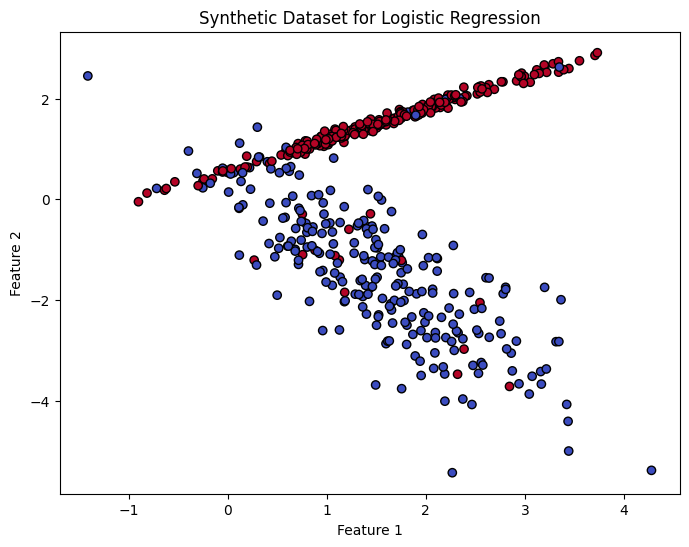

In [22]:
# Generate synthetic data.
X, y = make_classification(
    n_samples=500, n_features=2, n_informative=2, n_redundant=0, 
    n_clusters_per_class=1, class_sep=1.5, flip_y=0.1, random_state=42
)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("Synthetic Dataset for Logistic Regression")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Augment the feature matrix X by adding a bias column of ones.
X = np.hstack([X, np.ones((X.shape[0], 1))])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <a name="logistic_loss"></a> 2A. Loss Function (10 points)

The goal of logistic regression is to find the optimal weights that minimize the difference between predicted probabilities and true labels. To achieve this, we use gradient descent, an optimization algorithm that iteratively adjusts the model's parameters. Before we dive into implementing gradient descent, you will first implement three functions that we'll make use of in our model parameter fitting. 

First, implement the `sigmoid` function, which takes a real value as input and returns a value between 0 and 1, representing the probability of belonging to a class. This should be one line of code implementing the following: 

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Next, implement `binary_cross_entropy`, which is the loss function the gradient descent algorithm will optimize. We talked about Binary Cross Entropy in the neural networks lecture, but the same principle applies for logistic regression: given an array of prediction probabilities `y_pred` and the corresponding true class labels `y_true`, BCE measures how far off the model predictions are. This should also be one line of code implementing:

$$
\text{Loss}(y, \hat{y}) = - \frac{1}{N} \sum_{i=1}^N \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right)
$$

Finally, implement `loss_gradient`, which calculates the gradients of the loss function with respect to the model's parameters. The gradient for logistic regression is $\nabla_w \text{Loss} = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i) \mathbf{x}_i$, where $\mathbf{x}_i$ is the feature vector for the i-th sample. To see how we got this formula, you can try taking the gradient of the Loss equation above w.r.t. the weights by hand, as an optional (but very educational! :) ) exercise.

<div class="alert alert-info">
Implement the functions `sigmoid(z)`, `binary_cross_entropy(y_true, y_pred)`, and loss_gradient(X, y, y_pred) below.
</div>

In [23]:
# Sigmoid function
def sigmoid(z):
    """
    Compute the sigmoid of z.

    Input:
    - z : A scalar or numpy array of any size.

    Output:
    - The sigmoid of z.
    """
    return 1 / (1 + np.exp(-z))

# Binary cross-entropy loss
def binary_cross_entropy(y_true, y_pred):
    """
    Compute the binary cross-entropy loss.

    Inputs:
    - y_true : A numpy array of true binary labels (0 or 1).
    - y_pred : A numpy array of predicted probabilities (0 <= y_pred <= 1).

    Output:
    - The binary cross-entropy loss.
    """
    epsilon = 1e-15  # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def loss_gradient(X, y, y_pred):
    """
    Compute the gradients of the loss with respect to the augmented weights.

    Inputs:
    - X : A numpy array of shape (N, D+1), the augmented feature matrix.
    - y : A numpy array of shape (N,), the binary labels (0 or 1).
    - y_pred : A numpy array of shape (N,), the predicted probabilities.

    Output:
    - dw : A numpy array of shape (D+1,), the gradient of the loss with respect to w.
    """
    N = X.shape[0]
    return (1/N) * np.dot(X.T, (y_pred - y))

In [24]:
"""Test your loss function code here."""
Grader.run_single_test_inline(TestPSet10, "test_05_loss_functions", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


### <a name="gradient_descent"></a> 2B. Gradient Descent (30 points)

You will now implement the **Gradient Descent** update rule for logistic regression. In class, we discussed that we can estimate the weights using Maximum Likelihood Estimation, and we wrote logistic regression as an optimization problem where we maximize the log-likelihood of the data given the parameters with gradient ascent. In practice, it's more common to convert the problem into a minimization problem (by negating the log-likelihood; sometimes this is called the *nll* in shorthand notation) and run gradient *descent*. In this problem, you will:
1. Implement batch gradient descent (process all data at once in a single update per epoch).
2. Implement stochastic gradient descent (process one data point at a time from the shuffled dataset).
3. Implement mini-batch gradient descent (process small batches of data from the shuffled dataset).

We provide you with the outer training loop, visualization functions, and evaluation inside `train_and_plot`. You should implement the functions `batch_gradient_descent`, `stochastic_gradient_descent`, and `mini_batch_gradient_descent`, each of which execute a single *epoch*, or iteration, or gradient descent. As a reminder, batch gradient descent makes a single update per epoch, stochastic gradient descent makes $N$ updates per epoch, and mini-batch gradient descent makes $N/J$ updates per epoch (where $J$ is the batch size).

<div class="alert alert-info">
Implement the functions `batch_gradient_descent(X, y, w, alpha)`, `stochastic_gradient_descent(X, y, w, alpha)`, `mini_batch_gradient_descent(X, y, w, alpha, batch_size)` below.
</div>

In [25]:
def train_and_plot(X_train, y_train, X_test, y_test, gd_type, alpha, epochs=100, batch_size=32):
    """
    Train the logistic regression model using the specified gradient descent method and plot the loss curve.

    Inputs:
    - X_train : Training data (N, D+1).
    - y_train : Training labels (N,).
    - X_test : Test data (M, D+1).
    - y_test : Test labels (M,).
    - gd_type : A string, either 'batch', 'stochastic', or 'mini_batch'.
    - alpha : A float, the learning rate.
    - epochs : An integer, the number of training epochs.
    - batch_size : An integer, the size of each mini-batch (used only for 'mini_batch').

    Outputs:
    - None. Prints accuracy and plots the loss curve.
    """
    # Initialize parameters.
    w = np.zeros(X_train.shape[1])
    losses = []

    for epoch in range(epochs):
        if gd_type == "batch":
            w = batch_gradient_descent(X_train, y_train, w, alpha)
        elif gd_type == "stochastic":
            w = stochastic_gradient_descent(X_train, y_train, w, alpha)
        elif gd_type == "mini_batch":
            w = mini_batch_gradient_descent(X_train, y_train, w, alpha, batch_size)
        else:
            raise ValueError("Invalid gd_type. Choose 'batch', 'stochastic', or 'mini_batch'.")

        # Compute loss for the current epoch for plotting purposes.
        y_pred_train = sigmoid(np.dot(X_train, w))
        loss = binary_cross_entropy(y_train, y_pred_train)
        losses.append(loss)

    # Plot the loss curve.
    plt.plot(losses, label=f"{gd_type} GD")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for {gd_type.capitalize()} GD")
    plt.legend()
    plt.show()

    # Plot decision boundary.
    plt.figure(figsize=(10, 5))
    for label, color in zip([0, 1], ['blue', 'red']):
        plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                    label=f"Class {label}", alpha=0.7, edgecolors='k', c=color)
    x_vals = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
    y_vals = -(w[0] / w[1]) * x_vals - (w[2] / w[1])  # Solve for x2
    plt.plot(x_vals, y_vals, label="Decision Boundary", color="black")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary and Data")
    plt.legend()
    plt.show()
    
    # Evaluate on test set
    y_pred_test = sigmoid(np.dot(X_test, w)) >= 0.5
    accuracy = np.mean(y_pred_test == y_test)
    print(f"{gd_type.capitalize()} GD Test Accuracy: {accuracy:.2f}")

# Batch Gradient Descent
def batch_gradient_descent(X, y, w, alpha):
    """
    Perform one step of batch gradient descent using loss_gradient.

    Inputs:
    - X : A numpy array of shape (N, D+1), the augmented feature matrix.
    - y : A numpy array of shape (N,), the binary labels (0 or 1).
    - w : A numpy array of shape (D+1,), the augmented weights.
    - alpha : A float, the learning rate.

    Output:
    - Updated weights w.
    """
    # Compute predictions for all data
    y_pred = sigmoid(np.dot(X, w))
    # Compute gradient using all data points
    grad = loss_gradient(X, y, y_pred)
    # Update weights
    w = w - alpha * grad
    return w

def stochastic_gradient_descent(X, y, w, alpha):
    """
    Perform one epoch of stochastic gradient descent using loss_gradient.
    Goes through the entire dataset randomly.

    Inputs:
    - X : A numpy array of shape (N, D+1), the augmented feature matrix.
    - y : A numpy array of shape (N,), the binary labels (0 or 1).
    - w : A numpy array of shape (D+1,), the augmented weights.
    - alpha : A float, the learning rate.

    Output:
    - Updated weights w.
    """
    N = X.shape[0]
    # Shuffle indices to randomize order
    indices = np.random.permutation(N)
    
    # Process one data point at a time
    for i in indices:
        # Get single data point (reshape to maintain 2D array structure)
        X_i = X[i:i+1]  # Shape (1, D+1)
        y_i = y[i:i+1]  # Shape (1,)
        # Compute prediction for this single point
        y_pred_i = sigmoid(np.dot(X_i, w))
        # Compute gradient for this single point
        grad = loss_gradient(X_i, y_i, y_pred_i)
        # Update weights
        w = w - alpha * grad
    
    return w

# Mini-Batch Gradient Descent
def mini_batch_gradient_descent(X, y, w, alpha, batch_size):
    """
    Perform one epoch of mini-batch gradient descent using loss_gradient.
    Goes through the entire dataset in random mini-batches.

    Inputs:
    - X : A numpy array of shape (N, D+1), the augmented feature matrix.
    - y : A numpy array of shape (N,), the binary labels (0 or 1).
    - w : A numpy array of shape (D+1,), the augmented weights.
    - alpha : A float, the learning rate.
    - batch_size : An integer, the number of samples in each mini-batch.

    Output:
    - Updated weights w.
    """
    N = X.shape[0]
    # Shuffle indices to randomize batches
    indices = np.random.permutation(N)
    
    # Process data in mini-batches
    for start in range(0, N, batch_size):
        # Get batch indices
        batch_indices = indices[start:start + batch_size]
        # Extract batch data
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        # Compute predictions for batch
        y_pred_batch = sigmoid(np.dot(X_batch, w))
        # Compute gradient for batch
        grad = loss_gradient(X_batch, y_batch, y_pred_batch)
        # Update weights
        w = w - alpha * grad
    
    return w

In [26]:
"""Test your BATCH gradient descent code here. NOTE: stochastic and mini_batch are not tested"""
Grader.run_single_test_inline(TestPSet10, "test_06_batch_gd", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


#### Let's test your code by visualizing the results (20 points):
We will be grading the below plots. **Do not modify the code below**. You should expect accuracies greater than 80\% for all three methods.

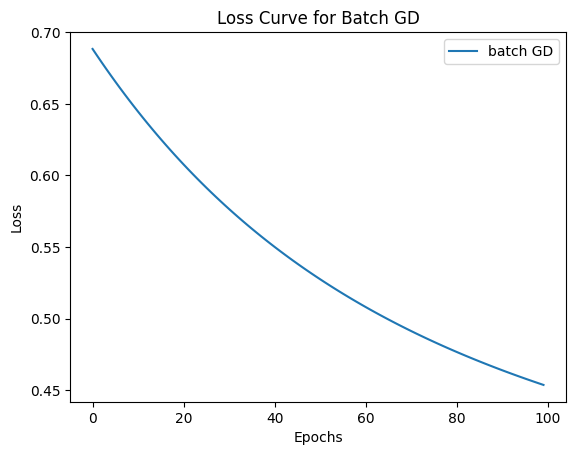

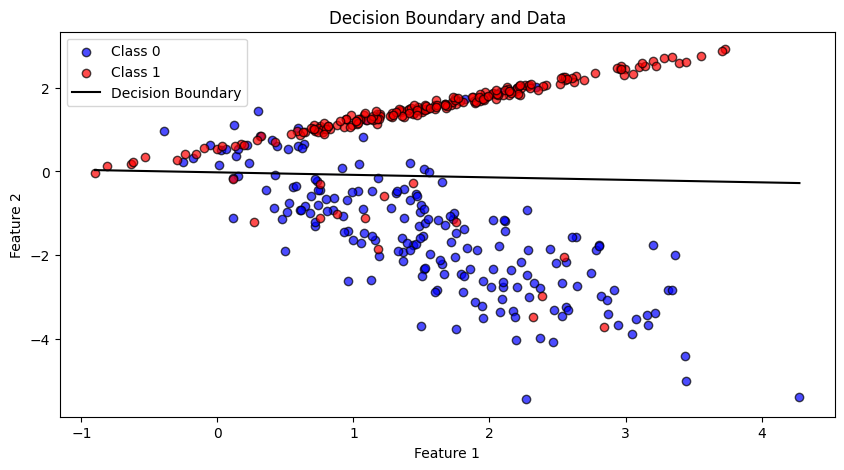

Batch GD Test Accuracy: 0.89


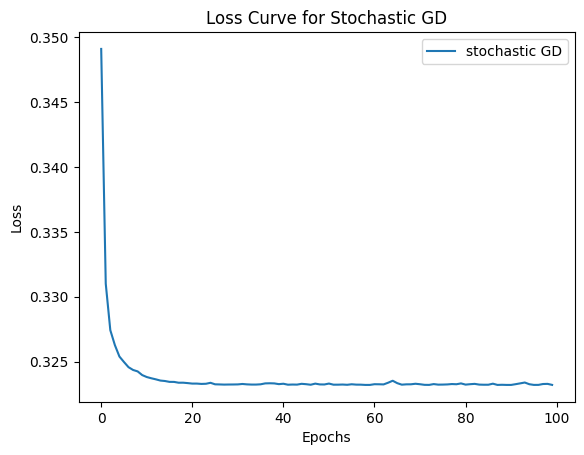

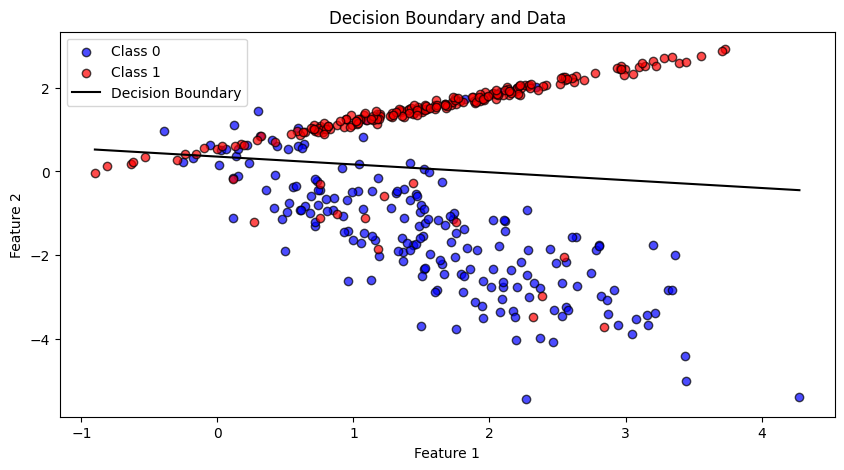

Stochastic GD Test Accuracy: 0.92


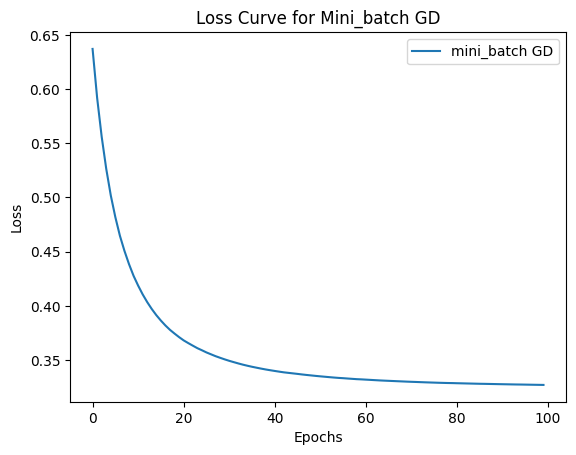

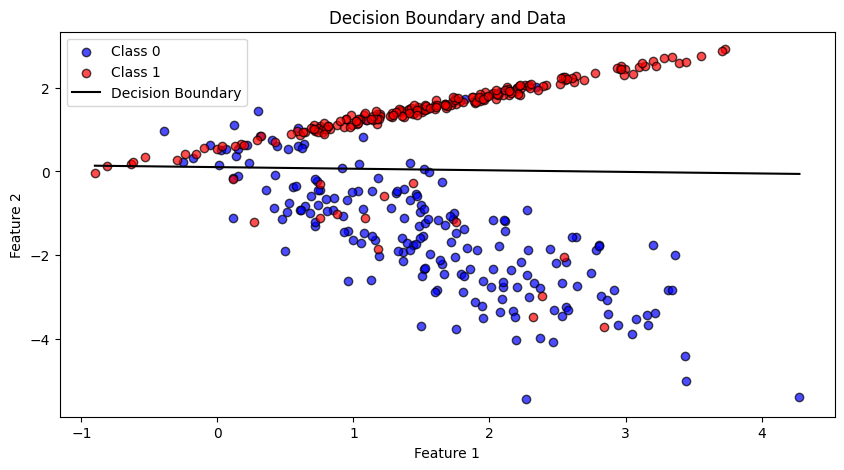

Mini_batch GD Test Accuracy: 0.91


In [27]:
epochs = 100
alpha = 0.01
batch_size = 32

train_and_plot(X_train, y_train, X_test, y_test, gd_type="batch", alpha=alpha, epochs=epochs)
train_and_plot(X_train, y_train, X_test, y_test, gd_type="stochastic", alpha=alpha, epochs=epochs)
train_and_plot(X_train, y_train, X_test, y_test, gd_type="mini_batch", alpha=alpha, epochs=epochs, batch_size=batch_size)

### <a name="learning_rate"></a> 2C. Learning Rate (10 points)

Try varying the learning rate parameter `alpha` in your run above, e.g. 0.001, 0.005, 0.01, 0.05, 0.1, 0.5.
- What are the best learning rates for each of the 3 gradient descent variants? What happens when the learning rate is too small? What about too large?
- Which method is more robust to large learning rates?
- Which method converges fastest when the learning rate is optimal?

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Batch GD: Works well with α ≈ 0.1-0.5. Since it uses the full dataset for each update, the gradient is stable and can tolerate larger learning rates.
Stochastic GD: Works best with smaller α ≈ 0.01-0.05. Individual sample gradients are noisy, so large learning rates cause erratic updates.
Mini-Batch GD: Performs well with α ≈ 0.05-0.1. It balances between batch and SGD, allowing moderate learning rates.

Batch gradient descent is the most robust to large learning rates because it computes the exact gradient over the entire dataset, resulting in stable and consistent updates. SGD is the least robust since single-sample gradients have high variance, and large learning rates amplify this noise, causing erratic behavior.

Stochastic gradient descent typically converges fastest in terms of epochs because it makes N updates per epoch (one per sample), allowing it to make rapid progress early in training. However, it may oscillate near the minimum. Mini-batch GD often provides the best practical tradeoff—faster than batch GD while being more stable than pure SGD.

## <a name="problem3"></a> (Optional) 3. Neural Networks

In this problem, you will define a **Neural Network**, train it with a given dataset, and explore overfitting prevention techniques, all with PyTorch. The goal of this problem is to take you through the journey of what training a neural network with modern autodiff packages looks like. Since PyTorch is almost a new language, you won't have to write too much code and when you do, we will provide guidance. You may want to befriend the [PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). 

First, we generate a dataset and split it into a training set, validation set, and test set. The difference between validation and test is that test is used for the final evaluation of the model (like before), and the validation set is meant for picking hyperparameters or early stopping.

In [29]:
# Generate dataset.
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Next, we convert this dataset to PyTorch tensors, which are specialized data structures that are very similar to numpy arrays, but with additional features that make them ideal for deep learning tasks (can run on GPUs or other hardware accelerators).

In [30]:
# Convert to PyTorch tensors.
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

Finally, we create DataLoaders, which will help handle the dataset batching that you had to do manually in mini-batch gradient descent.

In [31]:
# DataLoader for batching.
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

### <a name="define_NN"></a> 3A. Define Neural Network

Your task is to define a **3-layer fully connected neural network** for binary classification using PyTorch. The structure of the network is:
1. Input → Hidden Layer 1 → ReLU Activation.
2. Hidden Layer 1 → Hidden Layer 2 → ReLU Activation.
3. Hidden Layer 2 → Output Layer.

Complete the class `SimpleNN` below using `nn.Linear` for the fully connected layers and `nn.ReLU` for activations. Some helpful documentation:

1. `nn.Linear` usage: `nn.Linear(in_features, out_features)` implements a fully connected layer where `in_features` is the size of the input vector and `out_features` is the size of the output vector.
2. `nn.ReLU` usage: `nn.ReLU()` is an activation that introduces non-linearity in the model by applying the ReLU function: $\text{ReLU}(x) = \max(0, x)$.
3. `__init__` vs `forward`: `__init__` defines the network layers as class attributes, whereas `forward` specifies how data flows through the layers (i.e. how to combine/nest the layers together to go from input `x` to output).

<div class="alert alert-info">
Implement the `__init__` and `forward` methods below.
</div>

In [32]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)      # Input -> Hidden Layer 1
        self.relu1 = nn.ReLU()                               # ReLU activation
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)    # Hidden Layer 1 -> Hidden Layer 2
        self.relu2 = nn.ReLU()                               # ReLU activation
        self.fc3 = nn.Linear(hidden_size2, output_size)     # Hidden Layer 2 -> Output

    def forward(self, x):
        # Define how data flows through the network
        x = self.fc1(x)      # Input -> Hidden Layer 1
        x = self.relu1(x)    # ReLU activation
        x = self.fc2(x)      # Hidden Layer 1 -> Hidden Layer 2
        x = self.relu2(x)    # ReLU activation
        x = self.fc3(x)      # Hidden Layer 2 -> Output
        return x

Let's print your model. Make sure the in/out dimensions are compatible from layer to layer.

In [33]:
model = SimpleNN(
    input_size=2, 
    hidden_size1=16, 
    hidden_size2=8, 
    output_size=2
)
print(model)

SimpleNN(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)


In [34]:
"""Test your neural network code here."""
Grader.run_single_test_inline(TestPSet10, "test_07_NN", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.066s

OK


<div class="alert alert-info">
Answer the following multiple choice questions:
</div>

**Q1. Why might increasing the number of hidden layers improve performance?**

- (a) It helps the model capture more complex, non-linear patterns.
- (b) It reduces the risk of overfitting.
- (c) It makes training faster.
- (d) It is always better than adding more neurons to a single layer.

---

**Q2. Why don’t we apply an activation function (e.g., ReLU, sigmoid) to the output layer when using `CrossEntropyLoss`?**

- (a) The output layer doesn’t need to be non-linear.
- (b) The `CrossEntropyLoss` function internally applies `softmax`.
- (c) It makes training faster.
- (d) Activations don’t work well with binary classification.

In [35]:
# Enter your answer for the two above multiple multiple choice questions in the following tuple 
# # as (q1_ans, q2_ans) e.g. ('a', 'a')
mc_answer_set_1 = ('a', 'b')

# Commented out to prevent Gradescope errors
# raise NotImplementedError()

In [36]:
"""Check your multiple choice answers here."""
Grader.run_single_test_inline(TestPSet10, "test_08_NN_multiple", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


### <a name="overfitting"></a> 3B. Training with Early Stopping and Weight Regularization

In this part, you'll train the neural network you just defined with the dataset we gave you. We provide all of the training code (again, the important thing is understanding the training logic), but you will have to implement the `early_stopping` function and explore weight regularization in the optimization.

One of the (many) beauties of PyTorch is that we don't need to manually define the loss function or optimization algorithm like we did in the logistic regression problem. Instead, we only need these 2 lines of code:

In [37]:
### Commented out due to Gradescope errors - uncomment to complete the optional section!

criterion = nn.CrossEntropyLoss()  # Loss for classification tasks
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

Below we provide the training loop. Implement the `early_stopping` function, which given the current validation loss `val_loss` and the best validation loss so far `best_val_loss`, it determines if the loss hasn't been decreasing for longer than `patience` epochs, and if so, stops training.

<div class="alert alert-info">
Implement the `early_stopping` function below.
</div>

In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=10):
    """
    Train a PyTorch model using SGD and apply early stopping.

    Inputs:
    - model: The PyTorch model to train.
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - criterion: Loss function (e.g., nn.CrossEntropyLoss).
    - optimizer: Optimizer (e.g., torch.optim.SGD).
    - epochs: Number of training epochs.
    - patience: Number of epochs to wait for improvement in validation loss before stopping.

    Outputs:
    - train_losses: List of average training losses per epoch.
    - val_losses: List of average validation losses per epoch.
    """

    # Training parameters
    train_losses, val_losses = [], []
    best_val_loss = float("inf")  # For early stopping
    counter = 0  # Early stopping counter

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train() # Sets the model in training phase (lets gradients flow).
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()           # Reset gradients
            outputs = model(X_batch)        # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()                 # Backward pass (compute gradients)
            optimizer.step()                # Update weights
            epoch_train_loss += loss.item() # Accumulate training loss
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation phase
        model.eval() # Sets the model in evaluation phase (freezes the network, so gradients don't flow).
        epoch_val_loss = 0
        with torch.no_grad():  # No gradient computation during evaluation
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                epoch_val_loss += loss.item()
        val_losses.append(epoch_val_loss / len(val_loader))

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        # Apply early stopping
        best_val_loss, counter, stop_training = early_stopping(val_losses[-1], best_val_loss, counter, patience)
        if val_losses[-1] == best_val_loss:  # Save the model only if val_loss improves
            torch.save(model.state_dict(), "best_model.pth")
        if stop_training:
            break

    return train_losses, val_losses
        
def early_stopping(val_loss, best_val_loss, counter, patience):
    """
    Implements early stopping logic.

    Inputs:
    - val_loss: Current validation loss.
    - best_val_loss: Best validation loss seen so far.
    - counter: Current count of consecutive epochs without improvement.
    - patience: Number of epochs to wait before stopping.

    Outputs:
    - best_val_loss: Updated best validation loss.
    - counter: Updated counter value.
    - stop_training: Boolean flag indicating whether to stop training.
    """
    stop_training = False
    
    if val_loss < best_val_loss:
        # Validation loss improved - update best and reset counter
        best_val_loss = val_loss
        counter = 0
    else:
        # No improvement - increment counter
        counter += 1
        # Check if we've exceeded patience
        if counter >= patience:
            stop_training = True
            print(f"Early stopping triggered after {patience} epochs without improvement.")
    
    return best_val_loss, counter, stop_training

Now that we have the training loop, we can evaluate the model and visualize the loss curves.

Epoch 1/100, Train Loss: 0.6977, Val Loss: 0.6910
Epoch 2/100, Train Loss: 0.6860, Val Loss: 0.6800
Epoch 3/100, Train Loss: 0.6745, Val Loss: 0.6692
Epoch 4/100, Train Loss: 0.6632, Val Loss: 0.6583
Epoch 5/100, Train Loss: 0.6515, Val Loss: 0.6473
Epoch 6/100, Train Loss: 0.6399, Val Loss: 0.6365
Epoch 7/100, Train Loss: 0.6287, Val Loss: 0.6252
Epoch 8/100, Train Loss: 0.6165, Val Loss: 0.6133
Epoch 9/100, Train Loss: 0.6040, Val Loss: 0.6007
Epoch 10/100, Train Loss: 0.5911, Val Loss: 0.5873
Epoch 11/100, Train Loss: 0.5771, Val Loss: 0.5733
Epoch 12/100, Train Loss: 0.5618, Val Loss: 0.5586
Epoch 13/100, Train Loss: 0.5461, Val Loss: 0.5436
Epoch 14/100, Train Loss: 0.5300, Val Loss: 0.5281
Epoch 15/100, Train Loss: 0.5142, Val Loss: 0.5125
Epoch 16/100, Train Loss: 0.4983, Val Loss: 0.4971
Epoch 17/100, Train Loss: 0.4828, Val Loss: 0.4821
Epoch 18/100, Train Loss: 0.4670, Val Loss: 0.4673
Epoch 19/100, Train Loss: 0.4528, Val Loss: 0.4533
Epoch 20/100, Train Loss: 0.4389, Val Lo

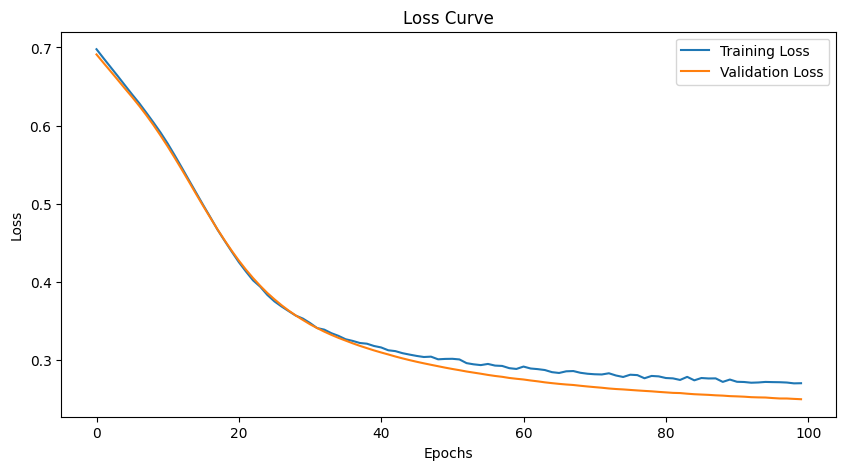

Test Accuracy: 88.50%


In [40]:
### Commented out due to Gradescope errors - uncomment to complete the optional section!

# Change these parameters.
decay = 0.001
patience = 10

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=decay)  # Adjust weight_decay as needed

# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=patience
)

# Plot loss curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Load the best model for evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluate on the test set
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get class predictions
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [41]:
"""Test your early stopping code here."""
Grader.run_single_test_inline(TestPSet10, "test_09_overfit", locals())

Early stopping triggered after 10 epochs without improvement.


Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<div class="alert alert-info">
Try varying the early stopping `patience` parameter and the weight regularization parameter `decay`. Then answer these multiple choice questions:
</div>

#### Multiple choice

Select which of the following statements are true (any number of them can be true):

**1. How does the patience parameter in early stopping affect training?**
- (a) Longer patience reduces the chance of stopping too early.
- (b) Shorter patience stops training faster but risks underfitting.
- (c) Patience only affects validation loss, not training.

---

**2. If validation loss fluctuates, how might patience help stabilize early stopping?**
- (a) Patience allows the model to continue training despite small fluctuations in validation loss.
- (b) Patience has no effect if validation loss is fluctuating.
- (c) Fluctuations in validation loss always indicate overfitting.


---

**3. Why does early stopping use validation loss instead of training loss?**
- (a) Validation loss better reflects generalization to unseen data.
- (b) Training loss decreases continuously and doesn’t indicate overfitting.
- (c) Validation loss is typically noisier, making it better for monitoring.

---

**4. What effect does weight decay have on training?**
- (a) It penalizes large weights, reducing overfitting.
- (b) It makes the training loss larger.
- (c) It speeds up convergence.
- (d) It has no effect on validation loss.


---

**5. What might happen if weight decay is set too high or too low?**
- (a) If too high, the model might underfit the data.
- (b) If too low, the model might overfit the training data.
- (c) Weight decay has no significant impact on training or validation.

In [42]:
# Mark the statements that are true for each of the above questions. 
# E.g. if A in question 1 is true set a=True in the q1 dict.

mc_answer_set_2 = dict(
    q1 = dict(a=True, b=True, c=False),
    q2 = dict(a=True, b=False, c=False),
    q3 = dict(a=True, b=True, c=False),
    q4 = dict(a=True, b=True, c=False, d=False),
    q5 = dict(a=True, b=True, c=False),
)

# Commented out to prevent Gradescope errors
# raise NotImplementedError()

In [43]:
"""Test your multiple choice answers here."""
Grader.run_single_test_inline(TestPSet10, "test_10_overfit_choice", locals())

Test passed!!

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


# <a name="part4"></a> Time Spent on Pset (5 points)

Please use [this form](https://forms.gle/dvGbdxsTZMLdSUBz5) to tell us how long you spent on this pset. After you submit the form, the form will give you a confirmation word. Please enter that confirmation word below to get an extra 5 points. 

In [44]:
form_confirmation_word = "Sock"

In [45]:
# Run all tests
Grader.grade_output([TestPSet10], [locals()], "results.json")
Grader.print_test_results("results.json")

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Test passed!!

Total score is 65/65.

Score for test_01_get_counts (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 10/10.

Score for test_02_learn_params (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 10/10.

Score for test_03_learn_distributions (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 10/10.

Score for test_04_NB_classify (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 10/10.

Score for test_05_loss_functions (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 10/10.

Score for test_06_batch_gd (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 10/10.

Score for test_07_NN (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 0/0.

Score for test_08_NN_multiple (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 0/0.

Score for test_09_overfit (principles_of_autonomy.notebook_tests.pset_10.TestPSet10) is 0/0.
- Early stopping triggered after 10 epochs without improvement.


Score for test_10_overf

In [ ]:
###############################################
#   SAVE YOUR NOTEBOOK BEFORE SUBMITTING!!!   #
###############################################

In [46]:
# Make sure you save the notebook before running this cell so that the most updated version is zipped!
Grader.prepare_submission("ProblemSet10_ML_release")

Open-ended responses written to ProblemSet10_ML_release_responses_only.ipynb
Compressed files in folder to ../ps10/ps10.zip (submit this to Gradescope)


/usr/local/lib/python3.10/dist-packages/nbformat/__init__.py:132: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
